In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- FAST VISION TRANSFORMER TRAINING ---

# --- Install dependencies ---
!pip install -q torch torchvision timm albumentations tqdm kaggle

# --- Kaggle Dataset Setup ---
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content"
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# --- Download and Unzip HAM10000 dataset ---
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip -d /content/HAM10000_images

# --- Imports ---
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import numpy as np
import random

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.18G/5.20G [02:16<00:00, 46.7MB/s]
100% 5.20G/5.20G [02:16<00:00, 40.8MB/s]
Using device: cuda


In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from torch.utils.data import Dataset

# --- Parameters ---
IMG_SIZE = 224  # ViT input size
AUG_TARGET_SIZE = 20000
BASE_DIR = "/content/HAM10000_images"
AUG_IMG_DIR = "/content/HAM10000_augmented"

os.makedirs(AUG_IMG_DIR, exist_ok=True)

# --- Load metadata ---
metadata = pd.read_csv(os.path.join(BASE_DIR, "HAM10000_metadata.csv"))

# Map diagnosis strings to numeric class labels
label_map = {label: idx for idx, label in enumerate(metadata['dx'].unique())}
metadata['label'] = metadata['dx'].map(label_map)
print("Label mapping:", label_map)

# --- Handle both image folders ---
IMG_DIRS = [
    os.path.join(BASE_DIR, "HAM10000_images_part_1"),
    os.path.join(BASE_DIR, "HAM10000_images_part_2")
]

def find_image_path(image_id):
    """Find an image file across multiple HAM10000 folders."""
    for d in IMG_DIRS:
        path = os.path.join(d, f"{image_id}.jpg")
        if os.path.exists(path):
            return path
    return None

# --- Base Transform (ViT normalization) ---
base_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# --- Strong Augmentation Pipeline ---
augment_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.4),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=25, p=0.5),
    A.RandomGamma(p=0.3),
    A.HueSaturationValue(p=0.3),
])

# --- Generate augmented dataset to reach 20,000 images ---
print("Creating augmented dataset...")

augmented_rows = []
n_original = len(metadata)
repeat_factor = int(np.ceil(AUG_TARGET_SIZE / n_original))

for _, row in tqdm(metadata.iterrows(), total=n_original):
    img_path = find_image_path(row['image_id'])
    if img_path is None:
        print(f"Skipping missing image: {row['image_id']}")
        continue

    image = np.array(Image.open(img_path).convert("RGB"))

    # Save original version
    base_filename = f"{row['image_id']}_orig.jpg"
    Image.fromarray(image).save(os.path.join(AUG_IMG_DIR, base_filename))
    augmented_rows.append({"image_id": base_filename.replace(".jpg", ""), "dx": row['dx'], "label": row['label']})

    # Create augmented copies
    for i in range(repeat_factor - 1):
        aug_image = augment_transform(image=image)["image"]
        aug_filename = f"{row['image_id']}_aug{i}.jpg"
        Image.fromarray(aug_image).save(os.path.join(AUG_IMG_DIR, aug_filename))
        augmented_rows.append({"image_id": aug_filename.replace(".jpg", ""), "dx": row['dx'], "label": row['label']})

# --- Build new metadata DataFrame ---
augmented_metadata = pd.DataFrame(augmented_rows)
augmented_metadata = augmented_metadata.sample(n=min(AUG_TARGET_SIZE, len(augmented_metadata)),
                                               random_state=42).reset_index(drop=True)

print(f"Augmented dataset size: {len(augmented_metadata)}")

# --- Dataset Class ---
class SkinDataset(Dataset):
    def __init__(self, dataframe, folder, transform=None):
        self.dataframe = dataframe
        self.folder = folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.folder, f"{row['image_id']}.jpg")
        image = np.array(Image.open(img_path).convert("RGB"))
        label = int(row['label'])

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, label

# --- Final dataset ---
dataset = SkinDataset(augmented_metadata, AUG_IMG_DIR, transform=base_transform)
print(f"Final dataset size: {len(dataset)}")

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Label mapping: {'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}
Creating augmented dataset...


100%|██████████| 10015/10015 [01:52<00:00, 89.26it/s] 

Augmented dataset size: 20000
Final dataset size: 20000


In [ ]:
from torch.utils.data import DataLoader, random_split, Subset
import random

# --- Optional: Use a subset for quick training/debug ---
subset_size = 1500  # small subset for fast epochs
indices = random.sample(range(len(dataset)), subset_size)
dataset = Subset(dataset, indices)
print(f"Using subset of {subset_size} images")

# --- Train/Validation Split ---
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")

# --- DataLoader Setup ---
batch_size = 16  # can increase to 32 if GPU memory allows

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

Using subset of 1500 images
Train: 1200, Val: 300


In [ ]:
# --- Model Setup: Vision Transformer for Classification ---
import timm
import torch.nn as nn
import torch

num_classes = 7  # HAM10000 has 7 diagnostic categories

# Load pretrained ViT model (ImageNet weights)
vit = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=num_classes
).to(device)

# Optionally, fine-tune only the classification head first
for param in vit.parameters():
    param.requires_grad = True  # set False if you want to freeze backbone

# --- Loss, Optimizer, AMP Setup ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(vit.parameters(), lr=1e-4, weight_decay=0.01)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

print(f"ViT model ready with {sum(p.numel() for p in vit.parameters() if p.requires_grad):,} trainable parameters")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViT model ready with 85,804,039 trainable parameters


/tmp/ipython-input-2676525599.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [ ]:
# --- Training Loop for ViT Classification ---
import torch
from torch.cuda.amp import autocast
from tqdm import tqdm
import os

epochs = 100  # fewer epochs for Colab
os.makedirs("outputs/vit", exist_ok=True)

print(f"Starting ViT training for {epochs} epochs...")

best_val_acc = 0.0

for epoch in range(epochs):
    vit.train()
    train_loss = 0.0
    correct = 0
    total = 0

    # --- Training ---
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=torch.cuda.is_available()):
            outputs = vit(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss /= total

    # --- Validation ---
    vit.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
            imgs, labels = imgs.to(device), labels.to(device)
            with autocast(enabled=torch.cuda.is_available()):
                outputs = vit(imgs)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss /= val_total

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # --- Save best model ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = f"outputs/vit/best_vit_epoch{epoch+1}_acc{val_acc:.4f}.pt"
        torch.save(vit.state_dict(), save_path)
        print(f"Saved best model: {save_path}")

Starting ViT training for 100 epochs...


Epoch 1/100 [Train]:   0%|          | 0/75 [00:00<?, ?it/s]/tmp/ipython-input-580076963.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
Epoch 1/100 [Val]:   0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipython-input-580076963.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
Epoch 1/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 19.55it/s]


Epoch 1/100 | Train Loss: 1.2039, Acc: 0.6408 | Val Loss: 0.9634, Val Acc: 0.7033
Saved best model: outputs/vit/best_vit_epoch1_acc0.7033.pt


Epoch 2/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.68it/s]


Epoch 2/100 | Train Loss: 0.9523, Acc: 0.6900 | Val Loss: 0.9929, Val Acc: 0.6933


Epoch 3/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.41it/s]


Epoch 3/100 | Train Loss: 0.8975, Acc: 0.6925 | Val Loss: 0.9054, Val Acc: 0.6733


Epoch 4/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 15.37it/s]


Epoch 4/100 | Train Loss: 0.8085, Acc: 0.7092 | Val Loss: 0.8290, Val Acc: 0.7033


Epoch 5/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 13.86it/s]


Epoch 5/100 | Train Loss: 0.6914, Acc: 0.7558 | Val Loss: 0.8892, Val Acc: 0.7233
Saved best model: outputs/vit/best_vit_epoch5_acc0.7233.pt


Epoch 6/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 15.15it/s]


Epoch 6/100 | Train Loss: 0.5970, Acc: 0.7800 | Val Loss: 0.8156, Val Acc: 0.7333
Saved best model: outputs/vit/best_vit_epoch6_acc0.7333.pt


Epoch 7/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 17.98it/s]


Epoch 7/100 | Train Loss: 0.4623, Acc: 0.8342 | Val Loss: 0.9151, Val Acc: 0.6833


Epoch 8/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.49it/s]


Epoch 8/100 | Train Loss: 0.3924, Acc: 0.8625 | Val Loss: 0.9542, Val Acc: 0.7100


Epoch 9/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.03it/s]


Epoch 9/100 | Train Loss: 0.2919, Acc: 0.8950 | Val Loss: 1.2635, Val Acc: 0.7100


Epoch 10/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.40it/s]


Epoch 10/100 | Train Loss: 0.1871, Acc: 0.9367 | Val Loss: 1.1919, Val Acc: 0.7300


Epoch 11/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 20.95it/s]


Epoch 11/100 | Train Loss: 0.1478, Acc: 0.9517 | Val Loss: 1.1259, Val Acc: 0.6967


Epoch 12/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 19.88it/s]


Epoch 12/100 | Train Loss: 0.1387, Acc: 0.9550 | Val Loss: 1.2810, Val Acc: 0.7433
Saved best model: outputs/vit/best_vit_epoch12_acc0.7433.pt


Epoch 13/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 16.98it/s]


Epoch 13/100 | Train Loss: 0.1331, Acc: 0.9525 | Val Loss: 1.1574, Val Acc: 0.7267


Epoch 14/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 14.11it/s]


Epoch 14/100 | Train Loss: 0.0926, Acc: 0.9642 | Val Loss: 1.4982, Val Acc: 0.7367


Epoch 15/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 14.87it/s]


Epoch 15/100 | Train Loss: 0.0603, Acc: 0.9783 | Val Loss: 1.5732, Val Acc: 0.7500
Saved best model: outputs/vit/best_vit_epoch15_acc0.7500.pt


Epoch 16/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 15.31it/s]


Epoch 16/100 | Train Loss: 0.0314, Acc: 0.9883 | Val Loss: 2.0665, Val Acc: 0.7467


Epoch 17/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.12it/s]


Epoch 17/100 | Train Loss: 0.0688, Acc: 0.9842 | Val Loss: 1.4990, Val Acc: 0.7200


Epoch 18/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 20.58it/s]


Epoch 18/100 | Train Loss: 0.0685, Acc: 0.9767 | Val Loss: 1.8356, Val Acc: 0.7367


Epoch 19/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 20.73it/s]


Epoch 19/100 | Train Loss: 0.0770, Acc: 0.9717 | Val Loss: 1.4200, Val Acc: 0.7100


Epoch 20/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.76it/s]


Epoch 20/100 | Train Loss: 0.0449, Acc: 0.9867 | Val Loss: 1.3358, Val Acc: 0.7000


Epoch 21/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 20.84it/s]


Epoch 21/100 | Train Loss: 0.0533, Acc: 0.9783 | Val Loss: 1.6169, Val Acc: 0.7067


Epoch 22/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 16.21it/s]


Epoch 22/100 | Train Loss: 0.0348, Acc: 0.9900 | Val Loss: 1.5782, Val Acc: 0.6933


Epoch 23/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 13.67it/s]


Epoch 23/100 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 1.6264, Val Acc: 0.7400


Epoch 24/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 14.90it/s]


Epoch 24/100 | Train Loss: 0.0393, Acc: 0.9883 | Val Loss: 1.4243, Val Acc: 0.7200


Epoch 25/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.11it/s]


Epoch 25/100 | Train Loss: 0.0084, Acc: 0.9983 | Val Loss: 1.9860, Val Acc: 0.7300


Epoch 26/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.39it/s]


Epoch 26/100 | Train Loss: 0.1200, Acc: 0.9658 | Val Loss: 1.5116, Val Acc: 0.7300


Epoch 27/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.39it/s]


Epoch 27/100 | Train Loss: 0.0320, Acc: 0.9900 | Val Loss: 1.8397, Val Acc: 0.7233


Epoch 28/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.58it/s]


Epoch 28/100 | Train Loss: 0.0083, Acc: 0.9967 | Val Loss: 1.7123, Val Acc: 0.7333


Epoch 29/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.09it/s]


Epoch 29/100 | Train Loss: 0.0104, Acc: 0.9958 | Val Loss: 2.1843, Val Acc: 0.7167


Epoch 30/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 14.88it/s]


Epoch 30/100 | Train Loss: 0.0604, Acc: 0.9817 | Val Loss: 1.4414, Val Acc: 0.7133


Epoch 31/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 14.14it/s]


Epoch 31/100 | Train Loss: 0.0237, Acc: 0.9933 | Val Loss: 1.6796, Val Acc: 0.7433


Epoch 32/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 15.86it/s]


Epoch 32/100 | Train Loss: 0.0959, Acc: 0.9733 | Val Loss: 1.3378, Val Acc: 0.7300


Epoch 33/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.96it/s]


Epoch 33/100 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 1.4885, Val Acc: 0.7067


Epoch 34/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.39it/s]


Epoch 34/100 | Train Loss: 0.0356, Acc: 0.9892 | Val Loss: 1.3676, Val Acc: 0.7433


Epoch 35/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.74it/s]


Epoch 35/100 | Train Loss: 0.0374, Acc: 0.9908 | Val Loss: 1.4234, Val Acc: 0.7233


Epoch 36/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 22.06it/s]


Epoch 36/100 | Train Loss: 0.0219, Acc: 0.9942 | Val Loss: 1.9007, Val Acc: 0.7167


Epoch 37/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.39it/s]


Epoch 37/100 | Train Loss: 0.0652, Acc: 0.9817 | Val Loss: 1.4502, Val Acc: 0.7233


Epoch 38/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 14.88it/s]


Epoch 38/100 | Train Loss: 0.0729, Acc: 0.9783 | Val Loss: 1.3257, Val Acc: 0.7100


Epoch 39/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 13.65it/s]


Epoch 39/100 | Train Loss: 0.0640, Acc: 0.9800 | Val Loss: 1.8215, Val Acc: 0.7133


Epoch 40/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 14.96it/s]


Epoch 40/100 | Train Loss: 0.0245, Acc: 0.9925 | Val Loss: 1.4431, Val Acc: 0.7333


Epoch 41/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 19.89it/s]


Epoch 41/100 | Train Loss: 0.0209, Acc: 0.9958 | Val Loss: 1.6669, Val Acc: 0.7133


Epoch 42/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.36it/s]


Epoch 42/100 | Train Loss: 0.0155, Acc: 0.9942 | Val Loss: 1.6026, Val Acc: 0.7267


Epoch 43/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.80it/s]


Epoch 43/100 | Train Loss: 0.0012, Acc: 1.0000 | Val Loss: 1.9223, Val Acc: 0.7333


Epoch 44/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.31it/s]


Epoch 44/100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 1.9262, Val Acc: 0.7367


Epoch 45/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.35it/s]


Epoch 45/100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 1.9767, Val Acc: 0.7367


Epoch 46/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 13.97it/s]


Epoch 46/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.0120, Val Acc: 0.7333


Epoch 47/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 14.50it/s]


Epoch 47/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.0407, Val Acc: 0.7367


Epoch 48/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 18.17it/s]


Epoch 48/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.0682, Val Acc: 0.7367


Epoch 49/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.23it/s]


Epoch 49/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.0919, Val Acc: 0.7400


Epoch 50/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 20.38it/s]


Epoch 50/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.1155, Val Acc: 0.7400


Epoch 51/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.26it/s]


Epoch 51/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.1412, Val Acc: 0.7400


Epoch 52/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.64it/s]


Epoch 52/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.1689, Val Acc: 0.7400


Epoch 53/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 17.60it/s]


Epoch 53/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.2025, Val Acc: 0.7400


Epoch 54/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 15.17it/s]


Epoch 54/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.2442, Val Acc: 0.7400


Epoch 55/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 14.68it/s]


Epoch 55/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.2915, Val Acc: 0.7400


Epoch 56/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.70it/s]


Epoch 56/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.3467, Val Acc: 0.7400


Epoch 57/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.17it/s]


Epoch 57/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.4078, Val Acc: 0.7400


Epoch 58/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.98it/s]


Epoch 58/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.4688, Val Acc: 0.7400


Epoch 59/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 20.69it/s]


Epoch 59/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.5305, Val Acc: 0.7400


Epoch 60/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 17.23it/s]


Epoch 60/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.5902, Val Acc: 0.7400


Epoch 61/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 14.38it/s]


Epoch 61/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.6493, Val Acc: 0.7333


Epoch 62/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 14.92it/s]


Epoch 62/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.7018, Val Acc: 0.7333


Epoch 63/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.15it/s]


Epoch 63/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.7563, Val Acc: 0.7333


Epoch 64/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.37it/s]


Epoch 64/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.8002, Val Acc: 0.7333


Epoch 65/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.01it/s]


Epoch 65/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.8476, Val Acc: 0.7333


Epoch 66/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.22it/s]


Epoch 66/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.8919, Val Acc: 0.7367


Epoch 67/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 19.57it/s]


Epoch 67/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.9314, Val Acc: 0.7367


Epoch 68/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 14.46it/s]


Epoch 68/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 2.9712, Val Acc: 0.7367


Epoch 69/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 16.11it/s]


Epoch 69/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.0061, Val Acc: 0.7367


Epoch 70/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 22.15it/s]


Epoch 70/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.0413, Val Acc: 0.7367


Epoch 71/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.92it/s]


Epoch 71/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.0744, Val Acc: 0.7367


Epoch 72/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.21it/s]


Epoch 72/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.1050, Val Acc: 0.7367


Epoch 73/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.83it/s]


Epoch 73/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.1355, Val Acc: 0.7367


Epoch 74/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 14.22it/s]


Epoch 74/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.1636, Val Acc: 0.7367


Epoch 75/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 15.63it/s]


Epoch 75/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.1903, Val Acc: 0.7367


Epoch 76/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.79it/s]


Epoch 76/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.2179, Val Acc: 0.7367


Epoch 77/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.22it/s]


Epoch 77/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.2418, Val Acc: 0.7367


Epoch 78/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 20.66it/s]


Epoch 78/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.2648, Val Acc: 0.7367


Epoch 79/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 20.31it/s]


Epoch 79/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.2867, Val Acc: 0.7367


Epoch 80/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.18it/s]


Epoch 80/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.3090, Val Acc: 0.7367


Epoch 81/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 14.87it/s]


Epoch 81/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.3303, Val Acc: 0.7367


Epoch 82/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 15.89it/s]


Epoch 82/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.3510, Val Acc: 0.7367


Epoch 83/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.44it/s]


Epoch 83/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.3716, Val Acc: 0.7367


Epoch 84/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.08it/s]


Epoch 84/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.3897, Val Acc: 0.7367


Epoch 85/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.51it/s]


Epoch 85/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.4068, Val Acc: 0.7367


Epoch 86/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.04it/s]


Epoch 86/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.4241, Val Acc: 0.7367


Epoch 87/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.59it/s]


Epoch 87/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.4406, Val Acc: 0.7367


Epoch 88/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 14.57it/s]


Epoch 88/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.4569, Val Acc: 0.7367


Epoch 89/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 14.83it/s]


Epoch 89/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.4716, Val Acc: 0.7367


Epoch 90/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.97it/s]


Epoch 90/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.4849, Val Acc: 0.7367


Epoch 91/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.48it/s]


Epoch 91/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.4997, Val Acc: 0.7367


Epoch 92/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 20.86it/s]


Epoch 92/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.5143, Val Acc: 0.7367


Epoch 93/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 20.35it/s]


Epoch 93/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.5266, Val Acc: 0.7367


Epoch 94/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 15.80it/s]


Epoch 94/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.5389, Val Acc: 0.7367


Epoch 95/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 15.00it/s]


Epoch 95/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.5521, Val Acc: 0.7367


Epoch 96/100 [Val]: 100%|██████████| 19/19 [00:01<00:00, 18.83it/s]


Epoch 96/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.5659, Val Acc: 0.7367


Epoch 97/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.39it/s]


Epoch 97/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.5779, Val Acc: 0.7367


Epoch 98/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.47it/s]


Epoch 98/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.5908, Val Acc: 0.7367


Epoch 99/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.69it/s]


Epoch 99/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.6061, Val Acc: 0.7367


Epoch 100/100 [Val]: 100%|██████████| 19/19 [00:00<00:00, 21.35it/s]

Epoch 100/100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 3.6208, Val Acc: 0.7367


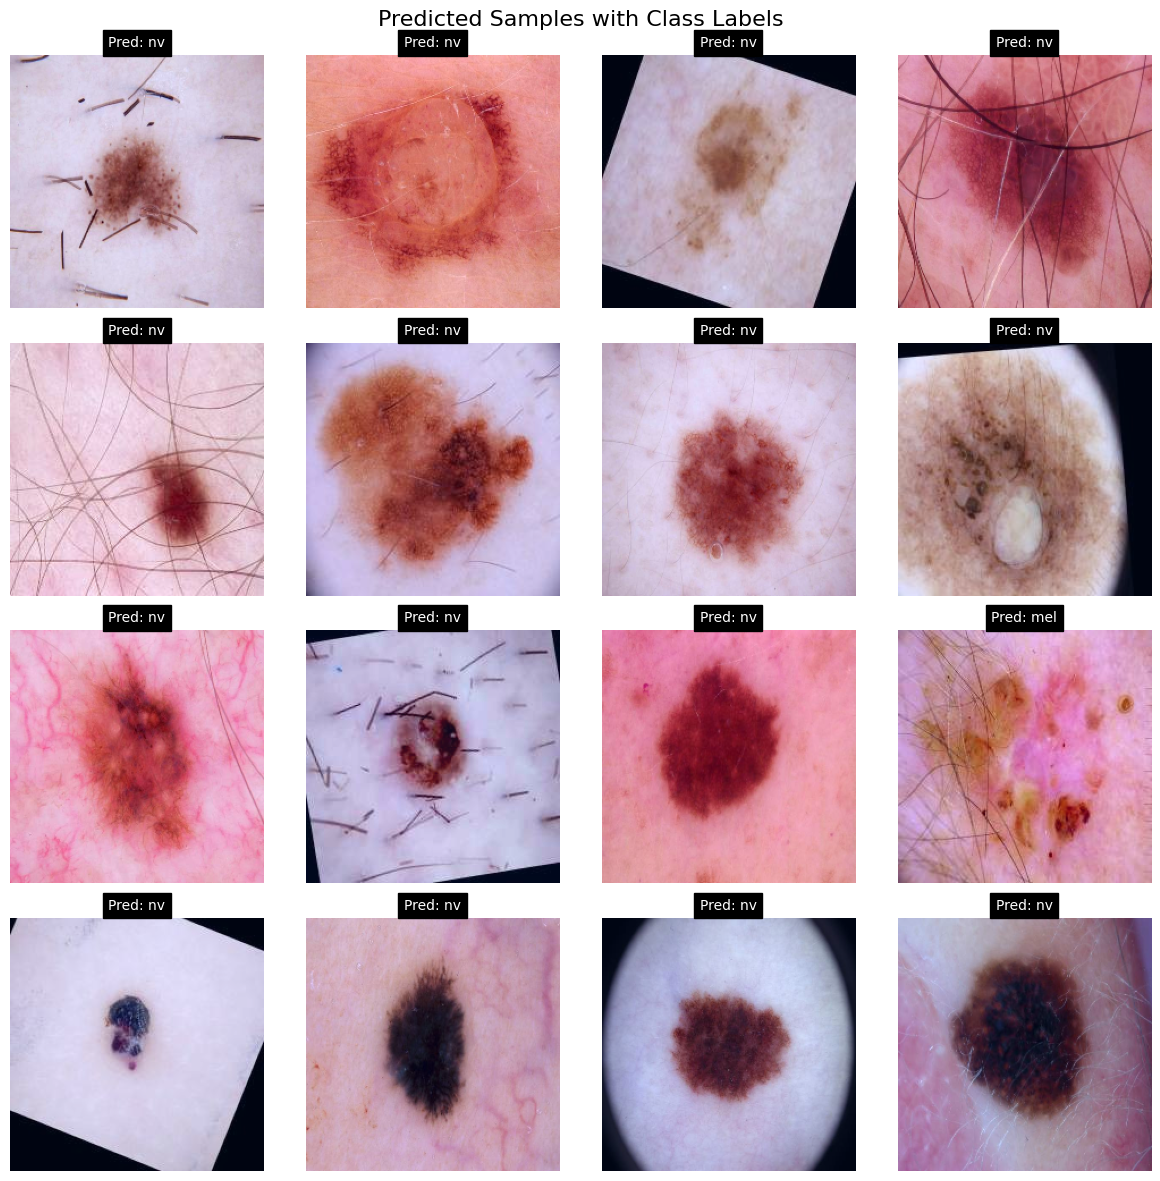

Labeled image saved at: outputs/vit/predicted_samples_labeled.png


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np
import os

# Your label mapping (from training)
label_map = {0: 'bkl', 1: 'nv', 2: 'df', 3: 'mel', 4: 'vasc', 5: 'bcc', 6: 'akiec'}

# Take a few validation samples
sample_imgs, sample_labels = next(iter(val_loader))
sample_imgs = sample_imgs.to(device)

# Predict
vit.eval()
with torch.no_grad():
    outputs = vit(sample_imgs)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for plotting
sample_imgs = sample_imgs.cpu()
preds = preds.cpu()

# Convert tensor to numpy for plotting
n_show = 16
ncols = 4
nrows = int(np.ceil(n_show / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12))
axes = axes.flatten()

for i in range(n_show):
    img = sample_imgs[i].permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for display

    axes[i].imshow(img)
    pred_label = label_map[int(preds[i])]
    axes[i].set_title(f"Pred: {pred_label}", fontsize=10, color='white', backgroundcolor='black')
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Predicted Samples with Class Labels", fontsize=16)
plt.tight_layout()
os.makedirs("outputs/vit", exist_ok=True)
plt.savefig("outputs/vit/predicted_samples_labeled.png", bbox_inches='tight', dpi=300)
plt.show()

print("Labeled image saved at: outputs/vit/predicted_samples_labeled.png")

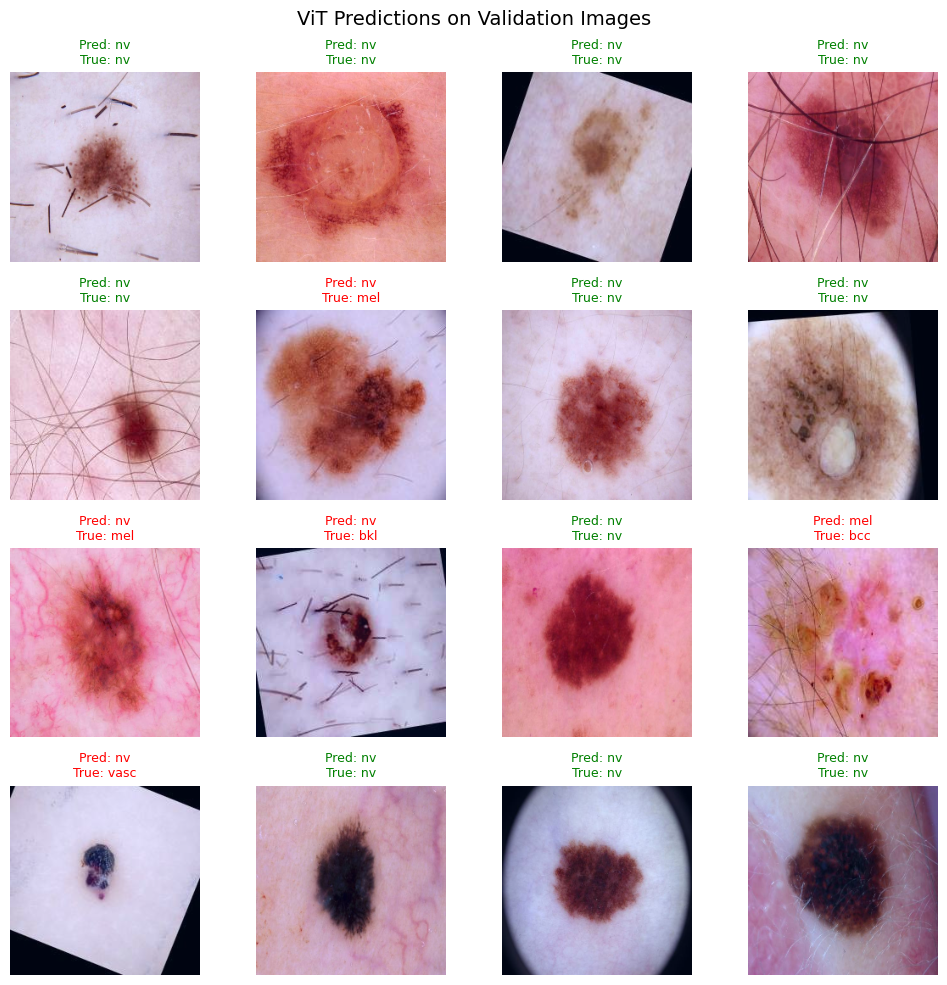

 Saved visualization: outputs/vit/predicted1_16_grid.png


In [ ]:
# ================================
# Show 16 Validation Samples with Predictions
# ================================
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
import os

vit.eval()
os.makedirs("outputs/vit", exist_ok=True)

# Label map (same order as training)
label_map = {0: 'bkl', 1: 'nv', 2: 'df', 3: 'mel', 4: 'vasc', 5: 'bcc', 6: 'akiec'}

# Get a small validation batch
sample_imgs, sample_labels = next(iter(val_loader))
sample_imgs, sample_labels = sample_imgs.to(device), sample_labels.to(device)

# Predict
with torch.no_grad():
    outputs = vit(sample_imgs)
    preds = torch.argmax(outputs, dim=1)

# Move to CPU for plotting
sample_imgs = sample_imgs.cpu()
preds = preds.cpu()
sample_labels = sample_labels.cpu()

# Show first 16 images
n_show = 16
ncols = 4
nrows = int(np.ceil(n_show / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
axes = axes.flatten()

for i in range(n_show):
    img = sample_imgs[i].permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())  # normalize [0,1]

    pred = label_map[int(preds[i])]
    true = label_map[int(sample_labels[i])]
    color = "green" if pred == true else "red"

    axes[i].imshow(img)
    axes[i].set_title(f"Pred: {pred}\nTrue: {true}", color=color, fontsize=9)
    axes[i].axis("off")

# Turn off any empty axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle("ViT Predictions on Validation Images", fontsize=14)
plt.tight_layout()
plt.savefig("outputs/vit/predicted1_16_grid.png", bbox_inches='tight', dpi=300)
plt.show()

print(" Saved visualization: outputs/vit/predicted1_16_grid.png")


In [ ]:
!pip install clean-fid

Fake Images Generation

 Evaluating ViT model on validation dataset...


100%|██████████| 19/19 [00:03<00:00,  5.17it/s]


Saved classification report: outputs/vit_predictions/classification_report.csv


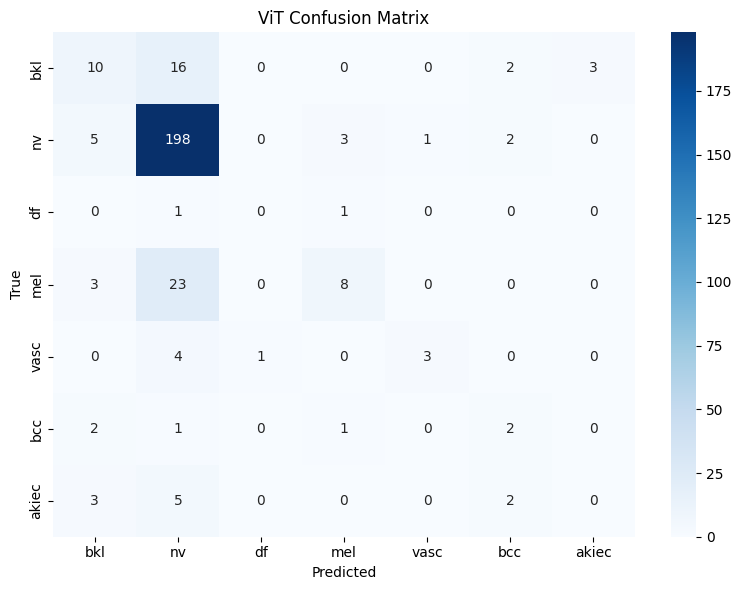

Saved confusion matrix: outputs/vit_predictions/confusion_matrix.png


In [ ]:
import os
from tqdm import tqdm
import torch
from torchvision.utils import save_image
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Evaluation Setup ---
vit.eval()
os.makedirs("outputs/vit_predictions", exist_ok=True)

all_preds, all_labels = [], []
label_map = {0: 'bkl', 1: 'nv', 2: 'df', 3: 'mel', 4: 'vasc', 5: 'bcc', 6: 'akiec'}

print(" Evaluating ViT model on validation dataset...")

with torch.no_grad():
    for imgs, labels in tqdm(val_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = vit(imgs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Compute Classification Report ---
report = classification_report(all_labels, all_preds, target_names=list(label_map.values()), output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv("outputs/vit_predictions/classification_report.csv", index=True)

print("Saved classification report: outputs/vit_predictions/classification_report.csv")

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_map.values()),
            yticklabels=list(label_map.values()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ViT Confusion Matrix")
plt.tight_layout()
plt.savefig("outputs/vit_predictions/confusion_matrix.png", dpi=300)
plt.show()

print("Saved confusion matrix: outputs/vit_predictions/confusion_matrix.png")

Real Images Generation

In [ ]:
import os
import random
import torch
from torchvision.utils import save_image
from tqdm import tqdm

# Create folder
os.makedirs("outputs/vit_real_predictions", exist_ok=True)

# Handle Subset correctly
if isinstance(dataset, torch.utils.data.Subset):
    base_dataset = dataset.dataset
    indices = dataset.indices
else:
    base_dataset = dataset
    indices = range(len(dataset))

# Randomly sample up to 500 real validation images
num_real = min(500, len(indices))
real_imgs = random.sample(indices, num_real)

vit.eval()
label_map = {0: 'bkl', 1: 'nv', 2: 'df', 3: 'mel', 4: 'vasc', 5: 'bcc', 6: 'akiec'}

print(f"Saving {num_real} real images with ViT predictions...")

for i, idx in enumerate(tqdm(real_imgs)):
    img, true_label = base_dataset[idx]
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = torch.argmax(vit(img), dim=1).item()

    # Move back to CPU and scale for saving
    img = img.squeeze(0).cpu()
    img = (img - img.min()) / (img.max() - img.min())

    # Save image with filename containing true/pred labels
    save_image(img, f"outputs/vit_real_predictions/{i:04d}_true-{label_map[true_label]}_pred-{label_map[pred]}.png")

print(f"Saved {num_real} labeled real images in outputs/vit_real_predictions/")

Saving 500 real images with ViT predictions...


100%|██████████| 500/500 [00:20<00:00, 23.86it/s]

Saved 500 labeled real images in outputs/vit_real_predictions/


Evalution Matrix

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import torch

print("Computing ViT performance metrics...")

vit.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = torch.argmax(vit(imgs), dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Metrics ---
acc = accuracy_score(all_labels, all_preds)
prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
report = classification_report(all_labels, all_preds, digits=3)

print("\n===========================")
print(" Vision Transformer Results")
print("===========================")
print(f" Accuracy:  {acc:.4f}")
print(f" Precision: {prec:.4f}")
print(f" Recall:    {rec:.4f}")
print(f" F1-score:  {f1:.4f}")
print("\nDetailed Report:\n")
print(report)

Computing ViT performance metrics...

 Vision Transformer Results
 Accuracy:  0.7367
 Precision: 0.6959
 Recall:    0.7367
 F1-score:  0.6996

Detailed Report:

              precision    recall  f1-score   support

           0      0.435     0.323     0.370        31
           1      0.798     0.947     0.867       209
           2      0.000     0.000     0.000         2
           3      0.615     0.235     0.340        34
           4      0.750     0.375     0.500         8
           5      0.250     0.333     0.286         6
           6      0.000     0.000     0.000        10

    accuracy                          0.737       300
   macro avg      0.407     0.316     0.338       300
weighted avg      0.696     0.737     0.700       300



In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import numpy as np

print("Evaluating ViT model similarity and accuracy...")

vit.eval()
all_preds, all_labels = [], []
all_embeds = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Extracting features"):
        imgs, labels = imgs.to(device), labels.to(device)

        # Forward pass
        outputs = vit(imgs)

        # Get class predictions
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Optionally get embeddings (before classification head)
        if hasattr(vit, 'vit'):
            embeds = vit.vit(imgs).last_hidden_state.mean(dim=1)
        else:
            embeds = outputs  # fallback if not accessible
        all_embeds.append(embeds.cpu())

# Compute accuracy and F1
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

# Compute pairwise cosine similarity between embeddings of same-class samples
embeds = torch.cat(all_embeds, dim=0)
labels_tensor = torch.tensor(all_labels)
cos_sims = []
for c in torch.unique(labels_tensor):
    class_embeds = embeds[labels_tensor == c]
    if class_embeds.size(0) > 1:
        sim = F.cosine_similarity(
            class_embeds.unsqueeze(1), class_embeds.unsqueeze(0), dim=-1
        ).mean().item()
        cos_sims.append(sim)
avg_cosine_similarity = np.mean(cos_sims)

print("\n===============================")
print("ViT Evaluation Results")
print("===============================")
print(f"Accuracy: {acc:.4f}")
print(f"Weighted F1-score: {f1:.4f}")
print(f"Avg. Intra-class Cosine Similarity: {avg_cosine_similarity:.4f}")

Evaluating ViT model similarity and accuracy...


Extracting features: 100%|██████████| 19/19 [00:03<00:00,  4.87it/s]



ViT Evaluation Results
Accuracy: 0.7367
Weighted F1-score: 0.6996
Avg. Intra-class Cosine Similarity: 0.5148


In [ ]:
import os

save_path = '/content/drive/MyDrive/synthetic_outputs/vit'
os.makedirs(save_path, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving labeled images: 100%|██████████| 100/100 [00:04<00:00, 20.70it/s]


Saved 100 labeled images to: /content/drive/MyDrive/ViT_Results/labeled_images


Extracting embeddings: 100%|██████████| 1500/1500 [00:24<00:00, 60.94it/s]


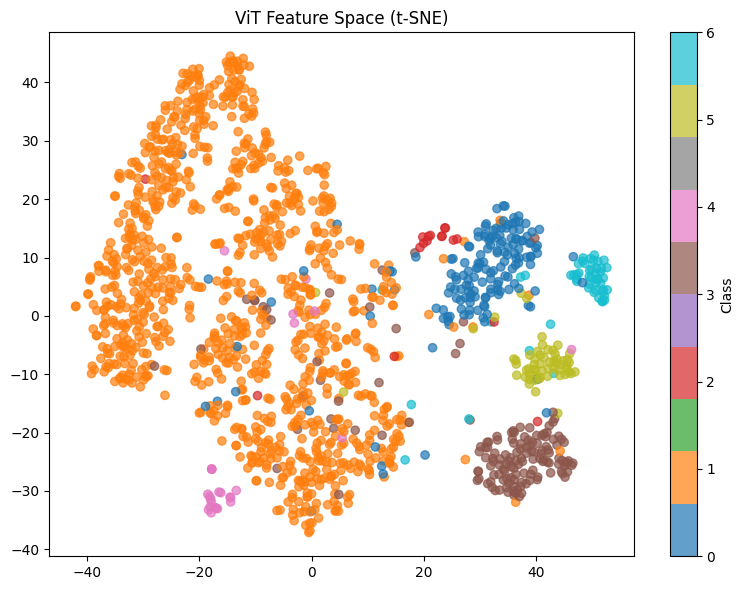

t-SNE plot saved to: /content/drive/MyDrive/ViT_Results/vit_tsne.png


In [ ]:
# ===========================
# Save ViT outputs to Drive
# ===========================
from google.colab import drive
import torch
from torchvision.utils import save_image
from PIL import Image, ImageDraw, ImageFont
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from tqdm import tqdm

# Mount Drive
drive.mount('/content/drive')

# Base save directory
save_dir = "/content/drive/MyDrive/ViT_Results"
os.makedirs(save_dir, exist_ok=True)
os.makedirs(f"{save_dir}/labeled_images", exist_ok=True)

# ---------------------------
# Save 100 labeled images
# ---------------------------
vit.eval()
num_samples = 100

class_names = list(label_map.values()) # Use label_map from previous cells

for i in tqdm(range(num_samples), desc="Saving labeled images"):
    img, label = dataset[i]
    with torch.no_grad():
        outputs = vit(img.unsqueeze(0).to(device))
        pred = torch.argmax(outputs, dim=1).item()

    # Convert tensor to PIL image
    img_pil = Image.fromarray(
        ((img.permute(1,2,0).cpu().numpy() * 255).clip(0,255)).astype(np.uint8)
    )

    # Add predicted label text
    draw = ImageDraw.Draw(img_pil)
    label_text = f"Pred: {class_names[pred]}"
    draw.text((10,10), label_text, fill=(255,0,0))

    img_pil.save(f"{save_dir}/labeled_images/sample_{i:03d}.png")

print(f"Saved 100 labeled images to: {save_dir}/labeled_images")

# ---------------------------
# 2️Create and save t-SNE
# ---------------------------
embeddings = []
labels = []

# Handle Subset correctly for embedding extraction
if isinstance(dataset, torch.utils.data.Subset):
    base_dataset = dataset.dataset
    indices_to_process = dataset.indices
else:
    base_dataset = dataset
    indices_to_process = range(len(dataset))


for i in tqdm(indices_to_process, desc="Extracting embeddings"):
    img, label = base_dataset[i]
    with torch.no_grad():
        # Assuming vit has an attribute for the backbone or a method to get features before the head
        if hasattr(vit, 'vit'): # Check if it's the timm vit structure
             # Extract features from the last hidden state, average over tokens
             feats = vit.vit(img.unsqueeze(0).to(device)).last_hidden_state.mean(dim=1)
        else:
             # If the structure is different, you might need to adapt this.
             # As a fallback, use the output before the final classification layer if possible.
             # This assumes the last layer is classifier.
             try:
                 feats = vit.forward_features(img.unsqueeze(0).to(device)).mean(dim=1)
             except:
                 print("Warning: Could not find standard ViT feature extraction. Using model output.")
                 feats = vit(img.unsqueeze(0).to(device))

        emb = feats.cpu().numpy()
    embeddings.append(emb)
    labels.append(label)

embeddings = np.concatenate(embeddings, axis=0)
labels = np.array(labels)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    emb_2d[:,0], emb_2d[:,1],
    c=labels, cmap='tab10', alpha=0.7
)
plt.colorbar(scatter, ticks=range(len(class_names)), label='Class')
plt.title("ViT Feature Space (t-SNE)")
plt.tight_layout()
plt.savefig(f"{save_dir}/vit_tsne.png", dpi=300)
plt.show()

print(f"t-SNE plot saved to: {save_dir}/vit_tsne.png")

In [ ]:
# If label_mapping not defined, rebuild it automatically from dataset folders
if 'label_mapping' not in globals():
    import os

    base_dir = "/content/HAM10000_images"
    classes = sorted([
        d for d in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, d))
    ])
    label_mapping = {cls_name: idx for idx, cls_name in enumerate(classes)}

print("Label mapping loaded:", label_mapping)
class_names = list(label_mapping.keys())

Label mapping loaded: {'HAM10000_images_part_1': 0, 'HAM10000_images_part_2': 1, 'ham10000_images_part_1': 2, 'ham10000_images_part_2': 3}
